In [1]:
import pandas as pd
import numpy as np
import numba
import swifter
from pandarallel import pandarallel
import dask
import perfplot
from math import log10
import matplotlib.pyplot as plt
import json
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
pandarallel.initialize()

/home/maga/projects/pandas/venv/lib/python3.7/site-packages/swifter/swifter.py:14: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.errors', please update to use 'numba.core.errors' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.errors import TypingError
/home/maga/projects/pandas/venv/lib/python3.7/site-packages/swifter/swifter.py:14: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'TypingError' requested from: 'numba.errors', please update to use 'numba.core.errors' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.errors import TypingError


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
from utils import perf_bench, plot_results, dump, load, mean_word_len

read_dumped = True

In [3]:
if read_dumped:
    results = load('results.json')
    mp_results = load('mp_results.json')
    pdr_results = load('pdr_results.json')
    swf_results = load('swf_results.json')
    swf_results_v = load('swf_results_v.json')
    md_results = load('md_results_ray.json')
    md_results_math = load('md_results_ray_math.json')
    dd_results = load('dd_results.json')

# Numba

In [10]:
df = pd.DataFrame(np.random.randint(0,100,size=(1000000, 4)),columns=['a', 'b', 'c', 'd'])
df.head()

,a,b,c,d
0,46,40,68,78
1,36,19,58,40
2,88,56,18,23
3,81,8,36,87
4,60,66,98,6


In [4]:
def square_mean(row):
    row = np.power(row, 2)
    return np.mean(row)

@numba.njit
def square_mean_v(arr):
    res = np.empty(arr.shape[0])
    arr = np.power(arr, 2)
    for i in range(len(arr)):
        res[i] = np.mean(arr[i])
    return res

In [5]:
def multiply(x):
    return x * 5


@numba.vectorize
def multiply_numba(x):
    return x * 5

In [9]:
# custom function
%timeit df['new_col'] = df['a'].apply(multiply)

# standard pandas implementation
%timeit df['new_col'] = df['a'] * 5

# custom function with numba
%timeit df['new_col'] = multiply_numba(df['a'].to_numpy())

6.15 ms ± 857 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.18 ms ± 179 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%time

df['new_col'] = square_mean_v(df.to_numpy())

In [42]:
%%time

df['new_col'] = df.apply(square_mean, axis=1)

CPU times: user 3min 53s, sys: 3.86 s, total: 3min 57s
Wall time: 3min 51s


In [11]:
log_n = int(log10(len(df)))

if not read_dumped:
    results = perf_bench(
        setup_f=lambda n: df.iloc[:n],
        kernels_f=[
            lambda df: df.apply(square_mean, axis=1),
            lambda df: square_mean_v(df.to_numpy()),
        ],
        n_range=np.logspace(1, log_n, log_n),
    )
    dump('results.json', results)
else:
    results = load('results.json')

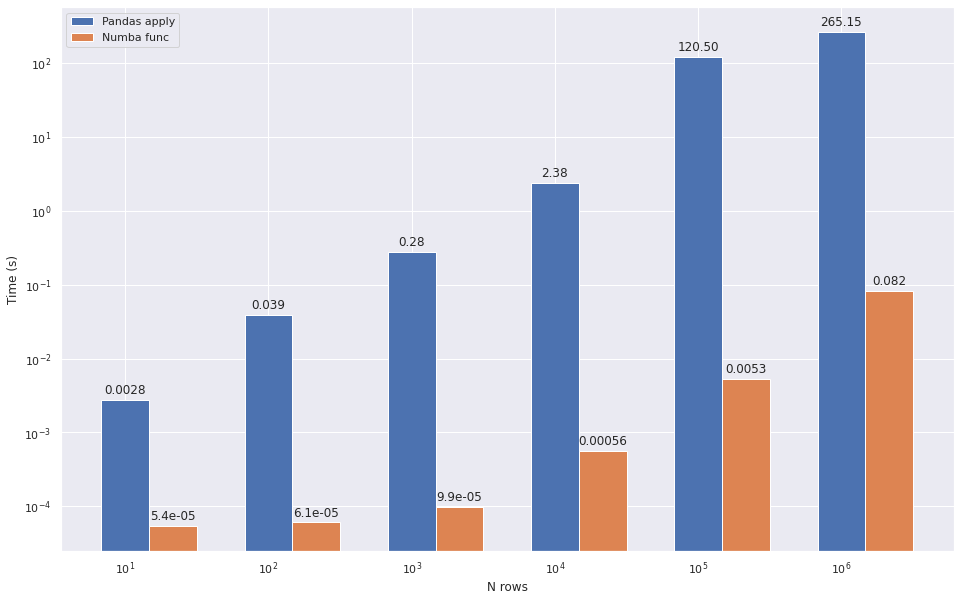

In [12]:
plot_results(results, ['Pandas apply', 'Numba func'], (1, log_n), 'numba.png')

In [10]:
results_n = np.array(results)
results_n[0] / results_n[1]

array([   50.79999734,   651.4690745 ,  2802.3964351 ,  4225.04931083,
       22543.61371668,  3236.89608147])

## Multiprocessing

In [42]:
df = pd.read_csv('abcnews-date-text.csv', header=0, usecols=['headline_text'])
df = pd.concat([df] * 10)
df.head()

,headline_text
0,aba decides against community broadcasting lic...
1,act fire witnesses must be aware of defamation
2,a g calls for infrastructure protection summit
3,air nz staff in aust strike for pay rise
4,air nz strike to affect australian travellers


In [48]:
def compute_avg_word(df):
    return df['headline_text'].apply(mean_word_len)

In [49]:
from multiprocessing import Pool

n_cores = 4
pool = Pool(n_cores)

def apply_parallel(df, func):
    df_split = np.array_split(df, n_cores)
    df = pd.concat(pool.map(func, df_split))
    return df

In [50]:
log_n = int(log10(len(df)))
n_range = np.logspace(2, log_n, log_n - 1)

if not read_dumped:
    mp_results = perf_bench(
        setup_f=lambda n: df.iloc[:n],
        kernels_f=[
            lambda df: apply_parallel(df, compute_avg_word),
            lambda df: df['headline_text'].apply(mean_word_len),
        ],
        n_range=n_range,
    )
    dump('mp_results.json', mp_results)
else:
    mp_results = load('mp_results.json')

N - 100, kernel #0: 0.006202 sec.
N - 1000, kernel #0: 0.01083 sec.
N - 10000, kernel #0: 0.03945 sec.
N - 100000, kernel #0: 0.2275 sec.
N - 1000000, kernel #0: 2.568 sec.
N - 10000000, kernel #0: 32.35 sec.
N - 100, kernel #1: 0.001701 sec.
N - 1000, kernel #1: 0.007994 sec.
N - 10000, kernel #1: 0.07705 sec.
N - 100000, kernel #1: 0.6889 sec.
N - 1000000, kernel #1: 8.369 sec.
N - 10000000, kernel #1: 67.5 sec.


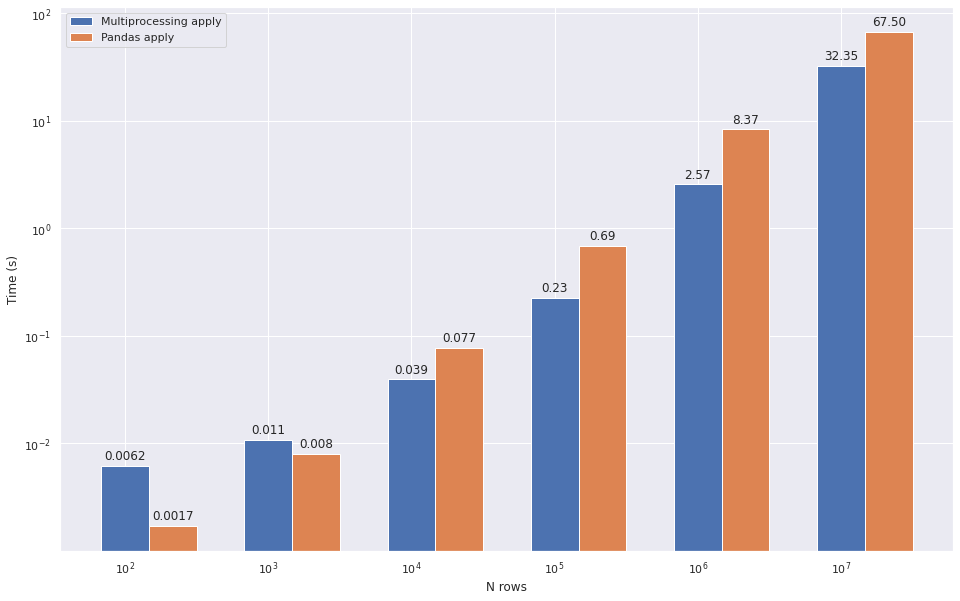

In [51]:
plot_results(mp_results, ['Multiprocessing apply', 'Pandas apply'], (2, log_n), 'multiprocessing.png')

In [52]:
results_n = np.array(mp_results)
print (results_n[1] / results_n[0])
pool.close()

[0.27428572 0.73832046 1.95321903 3.02881032 3.25879246 2.08636386]


## Pandarallel

In [53]:
df = pd.read_csv('abcnews-date-text.csv', header=0, usecols=['headline_text'])
df = pd.concat([df] * 10)
df.head()

,headline_text
0,aba decides against community broadcasting lic...
1,act fire witnesses must be aware of defamation
2,a g calls for infrastructure protection summit
3,air nz staff in aust strike for pay rise
4,air nz strike to affect australian travellers


In [4]:
pandarallel.initialize()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [56]:
from multiprocessing import Pool

n_cores = 4
pool = Pool(n_cores)

def apply_parallel(df, func):
    df_split = np.array_split(df, n_cores)
    df = pd.concat(pool.map(func, df_split))
    return df

In [57]:
log_n = int(log10(len(df)))
n_range = np.logspace(2, log_n, log_n - 1)

if not read_dumped:
    pdr_results = perf_bench(
        setup_f=lambda n: df.iloc[:n],
        kernels_f=[
            lambda df: df['headline_text'].parallel_apply(mean_word_len),
            lambda df: apply_parallel(df, compute_avg_word),
            lambda df: df['headline_text'].apply(mean_word_len),
        ],
        n_range=n_range,
    )
    dump('pdr_results.json', pdr_results)
else:
    pdr_results = load('pdr_results.json')

N - 100, kernel #0: 0.3775 sec.
N - 1000, kernel #0: 0.3436 sec.
N - 10000, kernel #0: 0.4535 sec.
N - 100000, kernel #0: 0.5929 sec.
N - 1000000, kernel #0: 2.636 sec.
N - 10000000, kernel #0: 28.88 sec.
N - 100, kernel #1: 0.004613 sec.
N - 1000, kernel #1: 0.006093 sec.
N - 10000, kernel #1: 0.02257 sec.
N - 100000, kernel #1: 0.2468 sec.
N - 1000000, kernel #1: 2.652 sec.
N - 10000000, kernel #1: 25.77 sec.
N - 100, kernel #2: 0.001783 sec.
N - 1000, kernel #2: 0.007906 sec.
N - 10000, kernel #2: 0.06637 sec.
N - 100000, kernel #2: 0.5991 sec.
N - 1000000, kernel #2: 6.087 sec.
N - 10000000, kernel #2: 61.29 sec.


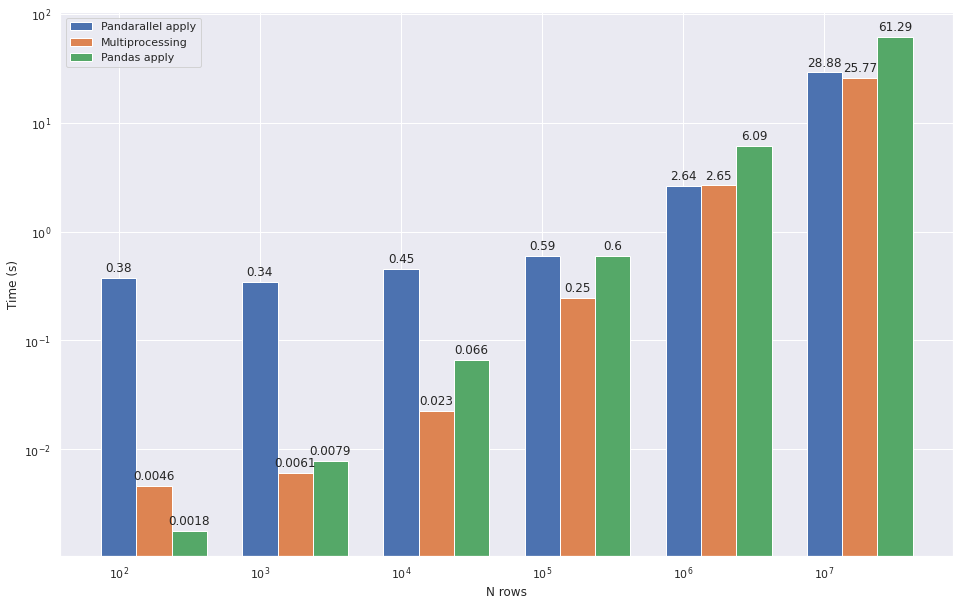

In [58]:
plot_results(pdr_results, ['Pandarallel apply', 'Multiprocessing', 'Pandas apply'], (2, log_n), 'pandarallel.png')

In [59]:
results_n = np.array(pdr_results)
results_n[1] / results_n[0]

array([0.01221902, 0.017731  , 0.04977223, 0.41632561, 1.00623878,
       0.89228738])

## Swifter

In [9]:
df = pd.read_csv('abcnews-date-text.csv', header=0)
df = pd.concat([df] * 10)
df.head()

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers


In [24]:
log_n = int(log10(len(df)))
n_range = np.logspace(2, log_n, log_n - 1)

if not read_dumped:
    swf_results_v = perf_bench(
        setup_f=lambda n: df.iloc[:n].publish_date,
        kernels_f=[
            lambda df: df.parallel_apply(multiply),
            lambda df: df.apply(multiply),
            lambda df: df.swifter.apply(multiply),
            lambda df: multiply(df)
        ],
        n_range=n_range,
    )
    dump('swf_results_v.json', swf_results_v)
else:
    swf_results_v = load('swf_results_v.json')

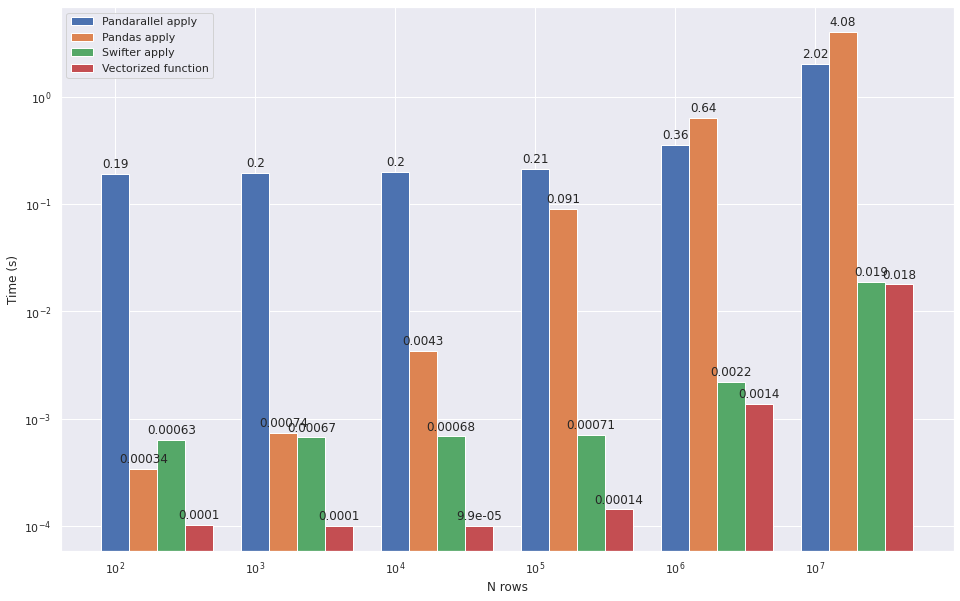

In [25]:
labels = ['Pandarallel apply', 'Pandas apply', 'Swifter apply', 'Vectorized function']
plot_results(swf_results_v, labels, (2, log_n), 'swifter_v.png')

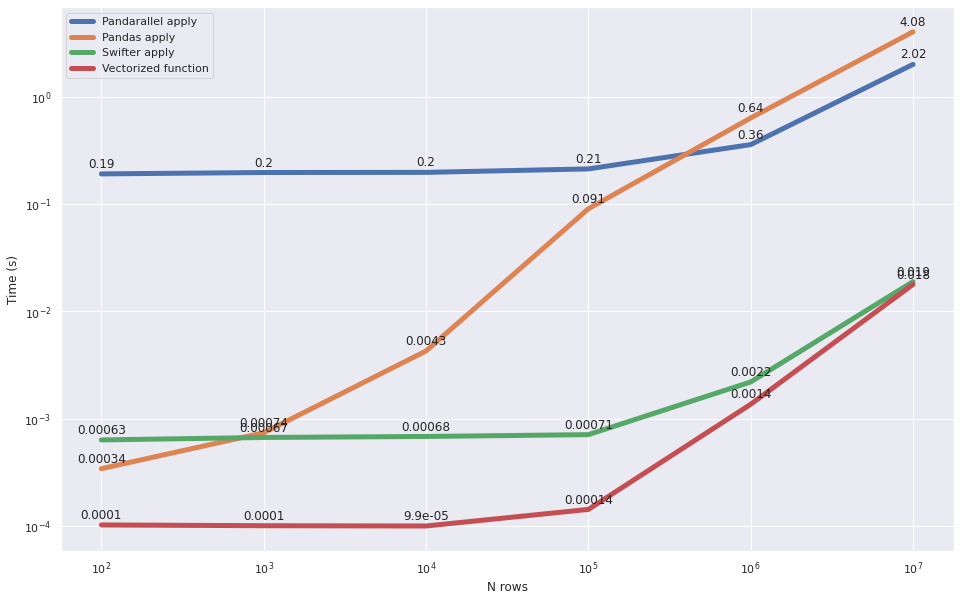

In [26]:
labels = ['Pandarallel apply', 'Pandas apply', 'Swifter apply', 'Vectorized function']
plot_results(swf_results_v, labels, (2, log_n), 'swifter_v_2.png', False)

In [61]:
log_n = int(log10(len(df)))
n_range = np.logspace(2, log_n, log_n - 1)

if not read_dumped:
    swf_results = perf_bench(
        setup_f=lambda n: df.iloc[:n].headline_text,
        kernels_f=[
            lambda df: df.parallel_apply(mean_word_len),
            lambda df: df.swifter.progress_bar(False).allow_dask_on_strings().apply(mean_word_len),
            lambda df: df.apply(mean_word_len),
        ],
        n_range=n_range,
    )
    dump('swf_results.json', swf_results)
else:
    swf_results = load('swf_results.json')

N - 100, kernel #0: 0.4454 sec.
N - 1000, kernel #0: 0.385 sec.
N - 10000, kernel #0: 0.4083 sec.
N - 100000, kernel #0: 0.5994 sec.
N - 1000000, kernel #0: 2.577 sec.
N - 10000000, kernel #0: 27.08 sec.
N - 100, kernel #1: 0.002778 sec.
N - 1000, kernel #1: 0.008824 sec.
N - 10000, kernel #1: 0.07829 sec.
N - 100000, kernel #1: 0.6213 sec.
N - 1000000, kernel #1: 4.79 sec.
N - 10000000, kernel #1: 30.81 sec.
N - 100, kernel #2: 0.001342 sec.
N - 1000, kernel #2: 0.007962 sec.
N - 10000, kernel #2: 0.07386 sec.
N - 100000, kernel #2: 0.6513 sec.
N - 1000000, kernel #2: 6.755 sec.
N - 10000000, kernel #2: 64.77 sec.


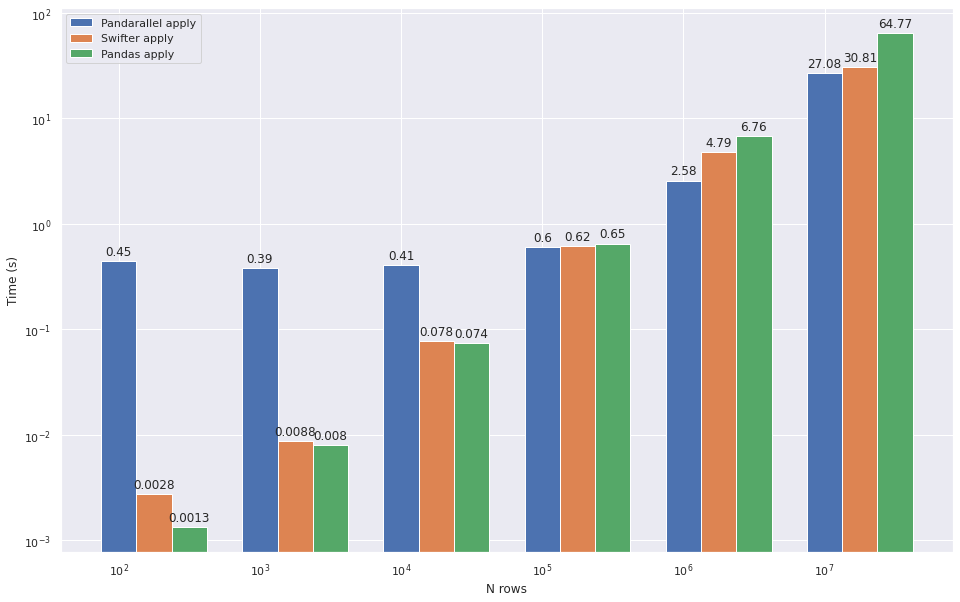

In [80]:
labels = ['Pandarallel apply', 'Swifter apply', 'Pandas apply']
plot_results(swf_results, labels, (2, log_n), 'swifter.png')

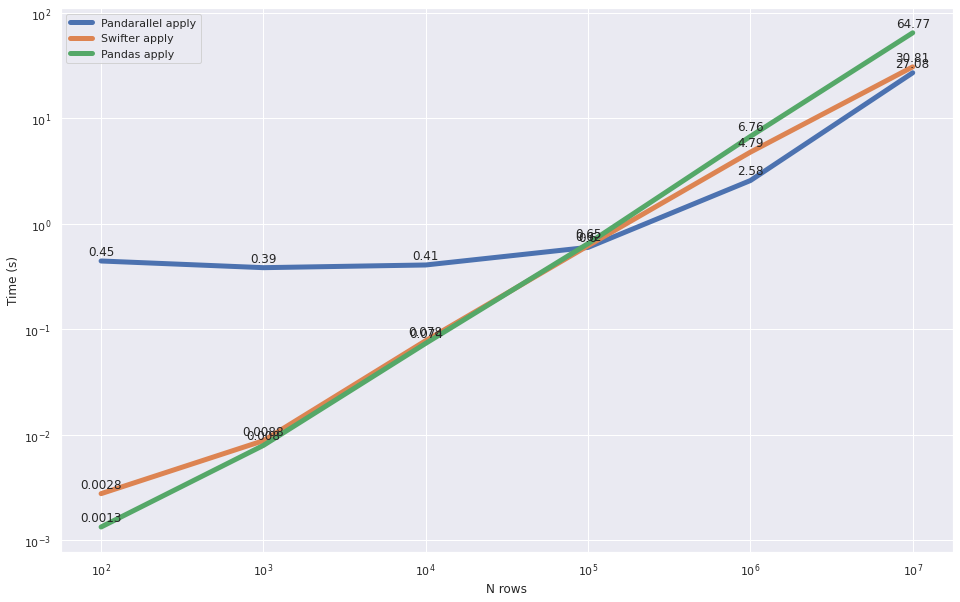

In [81]:
labels = ['Pandarallel apply', 'Swifter apply', 'Pandas apply']
plot_results(swf_results, labels, (2, log_n), 'swifter_2.png', False)

## Modin
Modin benchmarks script is located in modin_bench.py file

In [4]:
from distributed import Client

client = Client(n_workers=8)
%env MODIN_ENGINE=dask

env: MODIN_ENGINE=dask


In [5]:
import modin.pandas as mpd

In [107]:
# df = pd.read_csv('abcnews-date-text.csv', header=0)
# df = pd.concat([df] * 10)
# df.to_csv('big_csv.csv')

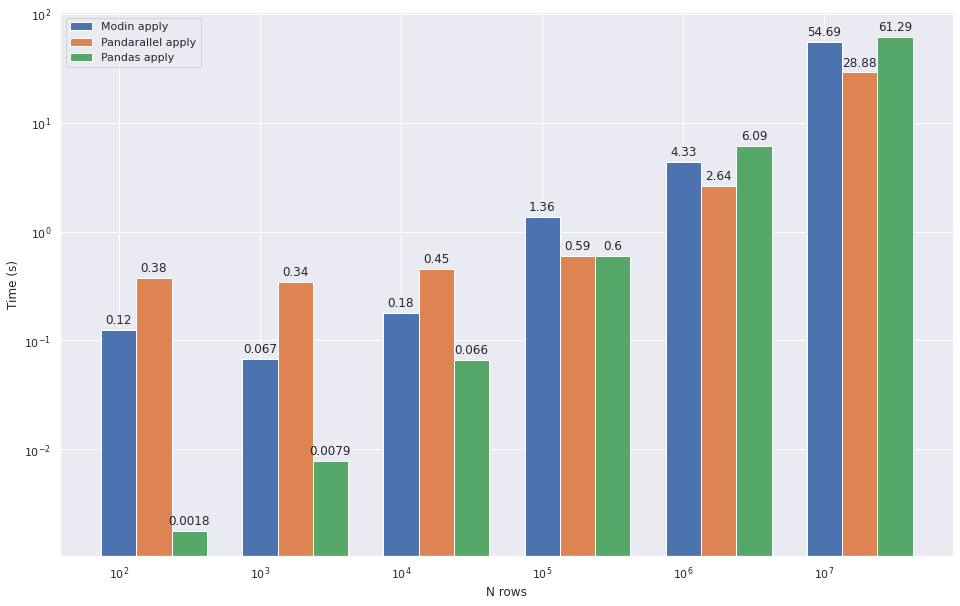

In [108]:
log_n = int(log10(len(df)))
labels = ['Modin apply', 'Pandarallel apply', 'Pandas apply']

plot_results(md_results,labels, (2, log_n), 'modin_dask.png')

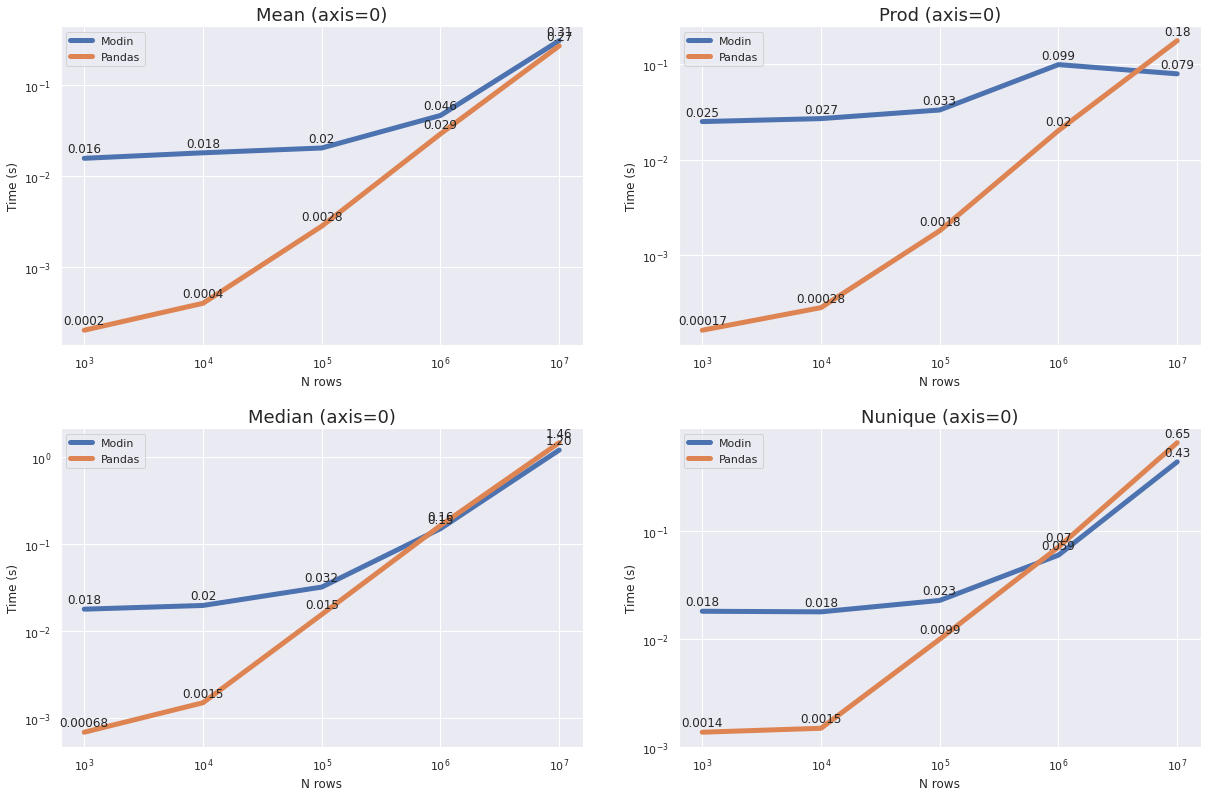

In [111]:
md_results_math = load('md_results_ray_math.json')
fig, axs = plt.subplots(2, 2, figsize=(18, 12))
fig.tight_layout(pad=5.0)

titles = ['Mean (axis=0)', 'Prod (axis=0)', 'Median (axis=0)', 'Nunique (axis=0)']
xy = [[0, 0], [0, 1], [1, 0], [1, 1]]
for idx, res_arr in enumerate(md_results_math):
    x, y = xy[idx]
    plot_results(res_arr, ['Modin', 'Pandas'], (3, 7), bar=False, ax=axs[x, y], title=titles[idx])
fig.savefig(f'static/modin_ray_math.png', formar='png', dpi=300, bbox_inches = 'tight', pad_inches = 0)

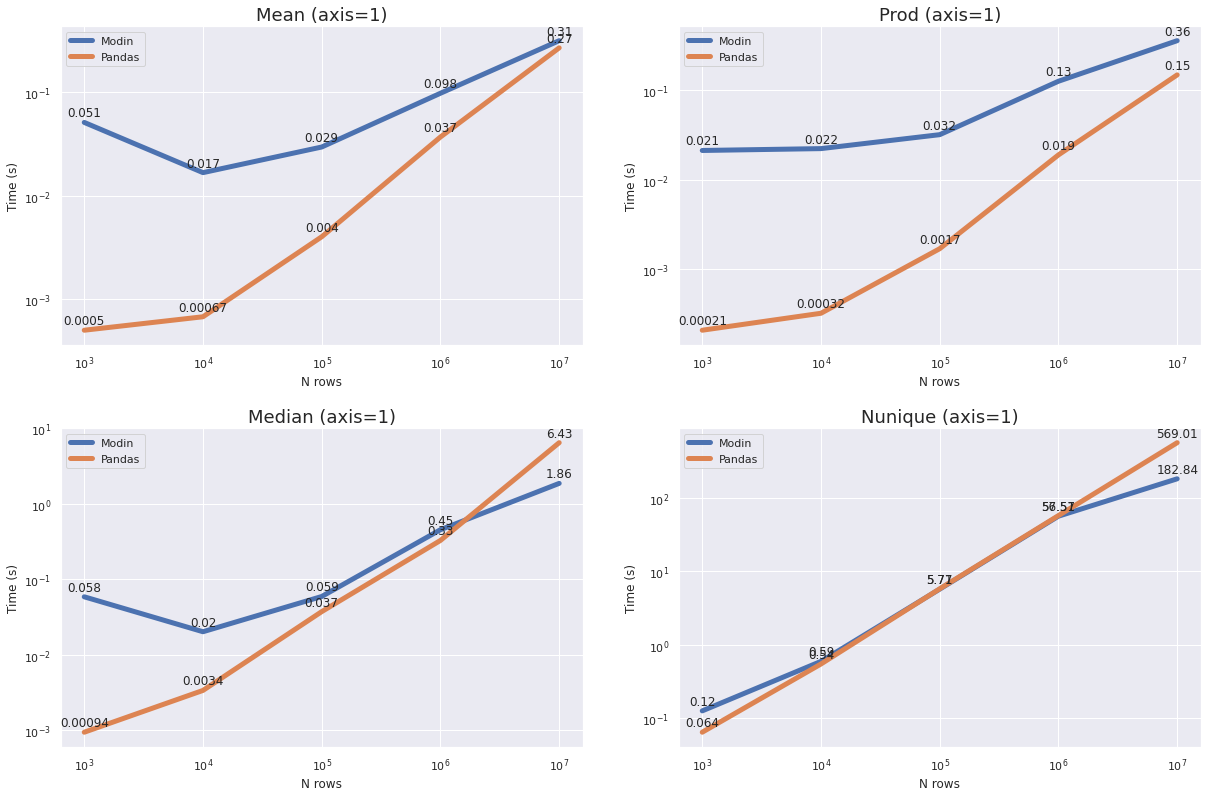

In [110]:
md_results_math = load('md_results_ray_math_2.json')
fig, axs = plt.subplots(2, 2, figsize=(18, 12))
fig.tight_layout(pad=5.0)

titles = ['Mean (axis=1)', 'Prod (axis=1)', 'Median (axis=1)', 'Nunique (axis=1)']
xy = [[0, 0], [0, 1], [1, 0], [1, 1]]
for idx, res_arr in enumerate(md_results_math):
    x, y = xy[idx]
    plot_results(res_arr, ['Modin', 'Pandas'], (3, 7), bar=False, ax=axs[x, y], title=titles[idx])
fig.savefig(f'static/modin_ray_math_2.png', formar='png', dpi=300, bbox_inches = 'tight', pad_inches = 0)

## Dask

In [4]:
from distributed import Client
import dask.dataframe as dd

client = Client(n_workers=8)

In [6]:
# we will convert it to Dask dataframe after getting slice with iloc
df = pd.read_csv('abcnews-date-text.csv', header=0)
df = pd.concat([df] * 10)

In [5]:
%%timeit

df_dd = dd.read_csv('big_csv.csv', header=0)
len(df_dd)

6.79 s ± 798 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%timeit pd.read_csv('big_csv.csv', header=0)

19.8 s ± 2.75 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
log_n = int(log10(len(df)))
n_range = np.logspace(2, log_n, log_n - 1)

if not read_dumped:
    dd_results = perf_bench(
        setup_f=lambda n: df.iloc[:n].headline_text,
        kernels_f=[
            lambda df: df.parallel_apply(mean_word_len),
            lambda df: df.swifter.progress_bar(False).allow_dask_on_strings().apply(mean_word_len),
            lambda df: dd.from_pandas(df, npartitions=8).apply(mean_word_len, meta=(float)).compute(),
            lambda df: df.apply(mean_word_len),
        ],
        n_range=n_range,
    )
    dump('dd_results.json', dd_results)
else:
    dd_results = load('dd_results.json')

N - 100, kernel #0: 0.4903 sec.
N - 1000, kernel #0: 0.3897 sec.
N - 10000, kernel #0: 0.383 sec.
N - 100000, kernel #0: 0.6124 sec.
N - 1000000, kernel #0: 2.827 sec.
N - 10000000, kernel #0: 30.68 sec.
N - 100, kernel #1: 0.003395 sec.
N - 1000, kernel #1: 0.01233 sec.
N - 10000, kernel #1: 0.09407 sec.
N - 100000, kernel #1: 0.7561 sec.
N - 1000000, kernel #1: 5.03 sec.
N - 10000000, kernel #1: 36.18 sec.
N - 100, kernel #2: 0.0453 sec.
N - 1000, kernel #2: 0.08279 sec.
N - 10000, kernel #2: 0.08591 sec.
N - 100000, kernel #2: 0.3254 sec.
N - 1000000, kernel #2: 3.227 sec.
N - 10000000, kernel #2: 31.4 sec.
N - 100, kernel #3: 0.001117 sec.
N - 1000, kernel #3: 0.007498 sec.
N - 10000, kernel #3: 0.07103 sec.
N - 100000, kernel #3: 0.7122 sec.
N - 1000000, kernel #3: 7.034 sec.
N - 10000000, kernel #3: 71.62 sec.


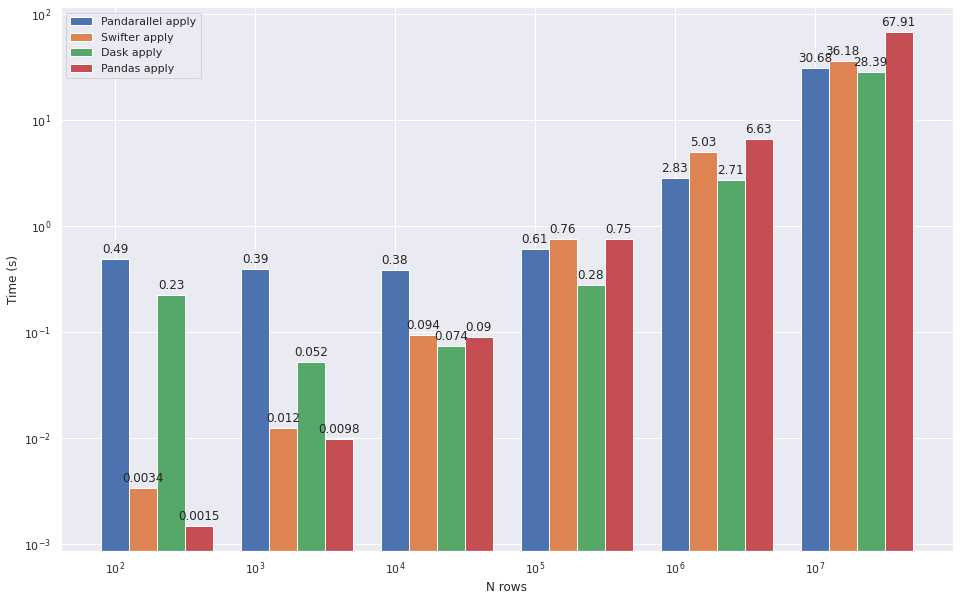

In [7]:
log_n = int(log10(len(df)))
labels = ['Pandarallel apply', 'Swifter apply', 'Dask apply', 'Pandas apply']

plot_results(dd_results,labels, (2, log_n), 'dask_results.png')

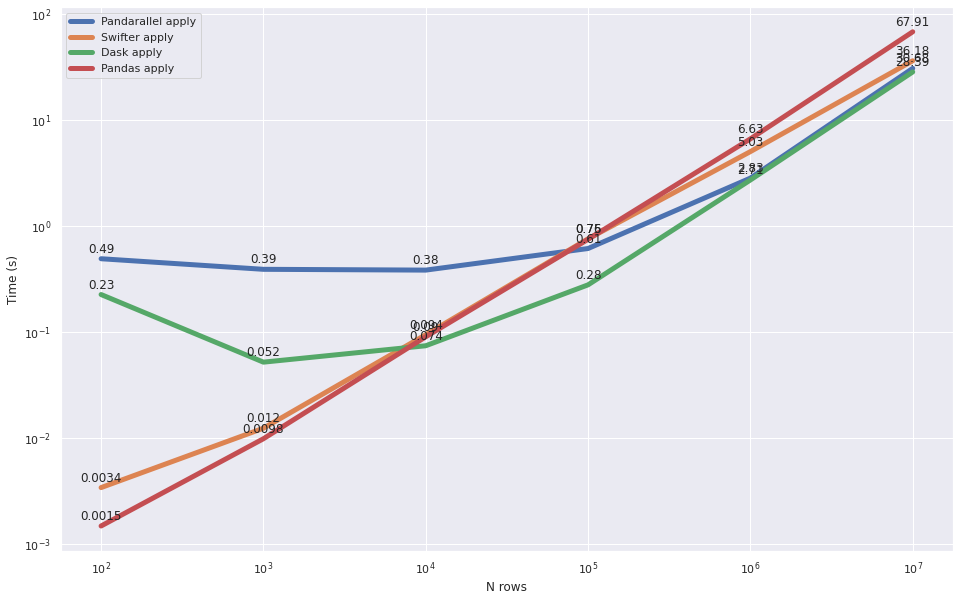

In [8]:
log_n = int(log10(len(df)))
labels = ['Pandarallel apply', 'Swifter apply', 'Dask apply', 'Pandas apply']

plot_results(dd_results,labels, (2, log_n), 'dask_results_line.png', False)

In [5]:
df = pd.DataFrame(np.random.randint(0, 100, size=(10**7, 4)), columns=list('adef'))

In [6]:
read_dumped = False

In [8]:
log_n = int(log10(len(df)))
n_range = np.logspace(3, log_n, log_n - 2)

def get_dd(n):
    return dd.from_pandas(df.iloc[:n], npartitions=8)

if not read_dumped:
    dd_results_math = perf_bench(
        setup_f=lambda n: get_dd(n),
        kernels_f=[
            lambda df: df.mean().compute(),
            lambda df: df.prod().compute(),
            lambda df: df.quantile().compute(),
            lambda df: df.sum().compute(),
        ],
        n_range=n_range,
    )
    
    pd_results_math = perf_bench(
        setup_f=lambda n: df.iloc[:n],
        kernels_f=[
            lambda df: df.mean(),
            lambda df: df.prod(),
            lambda df: df.median(),
            lambda df: df.sum(),
        ],
        n_range=n_range,
    )
    
    results = list(zip(dd_results_math, pd_results_math))
    dump('dd_results_math.json', results)
else:
    dd_results_math = load('dd_results_math.json')

N - 1000, kernel #0: 0.1338 sec.
N - 10000, kernel #0: 0.04809 sec.
N - 100000, kernel #0: 0.1218 sec.
N - 1000000, kernel #0: 0.3741 sec.
N - 10000000, kernel #0: 1.407 sec.
N - 1000, kernel #1: 0.0388 sec.
N - 10000, kernel #1: 0.0494 sec.
N - 100000, kernel #1: 0.04767 sec.
N - 1000000, kernel #1: 0.09287 sec.
N - 10000000, kernel #1: 0.4304 sec.
N - 1000, kernel #2: 0.4855 sec.
N - 10000, kernel #2: 0.1966 sec.
N - 100000, kernel #2: 0.1835 sec.
N - 1000000, kernel #2: 0.2856 sec.
N - 10000000, kernel #2: 1.558 sec.
N - 1000, kernel #3: 0.04545 sec.
N - 10000, kernel #3: 0.0663 sec.
N - 100000, kernel #3: 0.05425 sec.
N - 1000000, kernel #3: 0.1157 sec.
N - 10000000, kernel #3: 0.4825 sec.
N - 1000, kernel #0: 0.000578 sec.
N - 10000, kernel #0: 0.0005737 sec.
N - 100000, kernel #0: 0.008791 sec.
N - 1000000, kernel #0: 0.0367 sec.
N - 10000000, kernel #0: 0.2661 sec.
N - 1000, kernel #1: 0.0003145 sec.
N - 10000, kernel #1: 0.0004706 sec.
N - 100000, kernel #1: 0.002416 sec.
N - 1

In [12]:
if not read_dumped:
    dd_results_math_2 = perf_bench(
        setup_f=lambda n: get_dd(n),
        kernels_f=[
            lambda df: df.mean(axis=1).compute(),
            lambda df: df.prod(axis=1).compute(),
            lambda df: df.quantile(axis=1).compute(),
            lambda df: df.sum(axis=1).compute(),
        ],
        n_range=n_range,
    )
    
    pd_results_math_2 = perf_bench(
        setup_f=lambda n: df.iloc[:n],
        kernels_f=[
            lambda df: df.mean(axis=1),
            lambda df: df.prod(axis=1),
            lambda df: df.median(axis=1),
            lambda df: df.sum(axis=1),
        ],
        n_range=n_range,
    )
    
    results = list(zip(dd_results_math_2, pd_results_math_2))
    dump('dd_results_math_2.json', results)
else:
    dd_results_math_2 = load('dd_results_math_2.json')

N - 1000, kernel #0: 0.04958 sec.
N - 10000, kernel #0: 0.05698 sec.
N - 100000, kernel #0: 0.0725 sec.
N - 1000000, kernel #0: 0.1561 sec.
N - 10000000, kernel #0: 1.522 sec.
N - 1000, kernel #1: 0.03499 sec.
N - 10000, kernel #1: 0.03008 sec.
N - 100000, kernel #1: 0.0907 sec.
N - 1000000, kernel #1: 0.1948 sec.
N - 10000000, kernel #1: 1.464 sec.
N - 1000, kernel #2: 0.02838 sec.
N - 10000, kernel #2: 0.03948 sec.
N - 100000, kernel #2: 0.06802 sec.
N - 1000000, kernel #2: 0.2291 sec.
N - 10000000, kernel #2: 2.33 sec.
N - 1000, kernel #3: 0.08564 sec.
N - 10000, kernel #3: 0.07986 sec.
N - 100000, kernel #3: 0.09 sec.
N - 1000000, kernel #3: 0.1614 sec.
N - 10000000, kernel #3: 1.627 sec.
N - 1000, kernel #0: 0.006225 sec.
N - 10000, kernel #0: 0.00586 sec.
N - 100000, kernel #0: 0.01594 sec.
N - 1000000, kernel #0: 0.06031 sec.
N - 10000000, kernel #0: 0.3699 sec.
N - 1000, kernel #1: 0.0002103 sec.
N - 10000, kernel #1: 0.0003753 sec.
N - 100000, kernel #1: 0.001599 sec.
N - 1000

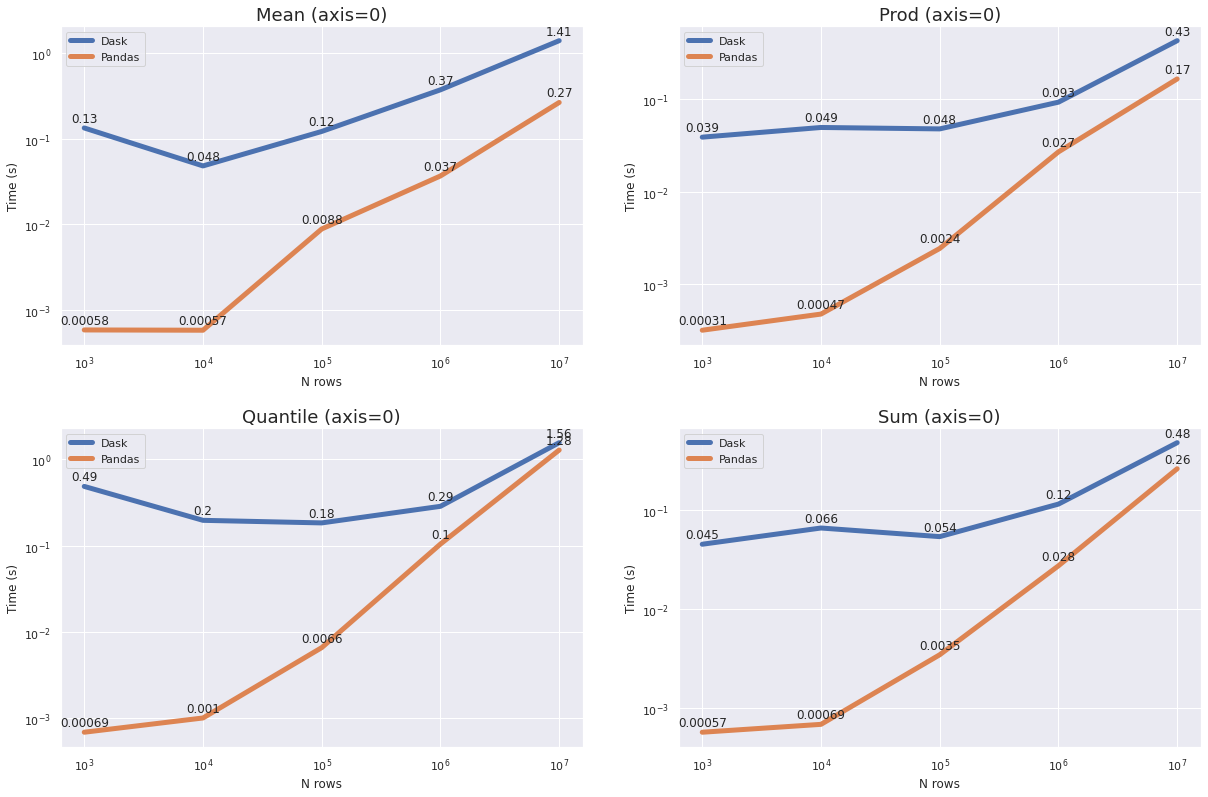

In [11]:
dd_results_math = load('dd_results_math.json')
fig, axs = plt.subplots(2, 2, figsize=(18, 12))
fig.tight_layout(pad=5.0)

titles = ['Mean (axis=0)', 'Prod (axis=0)', 'Quantile (axis=0)', 'Sum (axis=0)']
xy = [[0, 0], [0, 1], [1, 0], [1, 1]]
for idx, res_arr in enumerate(dd_results_math):
    x, y = xy[idx]
    plot_results(res_arr, ['Dask', 'Pandas'], (3, 7), bar=False, ax=axs[x, y], title=titles[idx])
fig.savefig(f'static/dd_results_math.png', formar='png', dpi=300, bbox_inches = 'tight', pad_inches = 0)

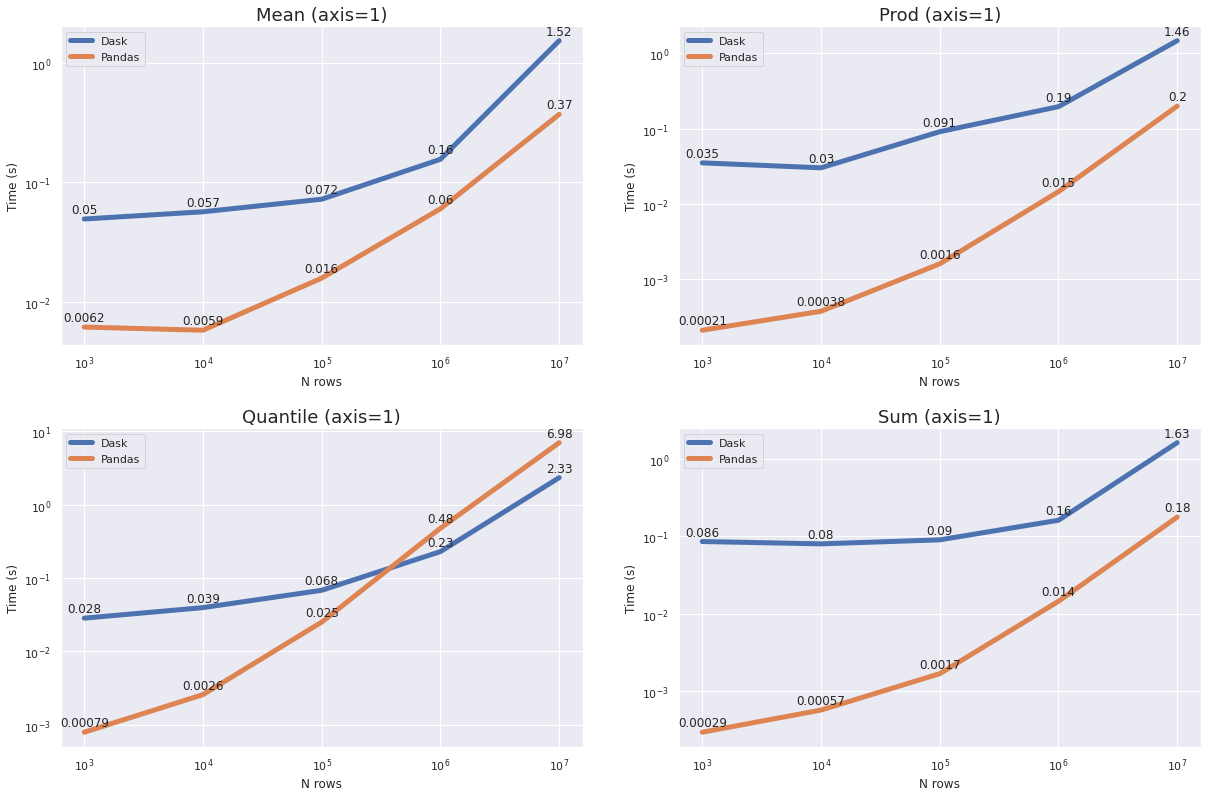

In [18]:
dd_results_math_2 = load('dd_results_math_2.json')
fig, axs = plt.subplots(2, 2, figsize=(18, 12))
fig.tight_layout(pad=5.0)

titles = ['Mean (axis=1)', 'Prod (axis=1)', 'Quantile (axis=1)', 'Sum (axis=1)']
xy = [[0, 0], [0, 1], [1, 0], [1, 1]]
for idx, res_arr in enumerate(dd_results_math_2):
    x, y = xy[idx]
    plot_results(res_arr, ['Dask', 'Pandas'], (3, 7), bar=False, ax=axs[x, y], title=titles[idx])
fig.savefig(f'static/dd_results_math_2.png', formar='png', dpi=300, bbox_inches = 'tight', pad_inches = 0)